# Лабораторная работа № 8

## Загрузка данных



In [53]:
!mkdir -p /content/drive/MyDrive/Kaggle

In [54]:
!pip install -q kaggle

from google.colab import drive
drive.mount('/content/drive')


!ls /content/drive/MyDrive/Kaggle/


!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


!mkdir -p /content/drive/MyDrive/Prepare_Data
%cd /content/drive/MyDrive/Prepare_Data


!kaggle datasets download andrewmvd/face-mask-detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json
/content/drive/MyDrive/Prepare_Data
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!unzip "/content/drive/MyDrive/Prepare_Data/face-mask-detection.zip" -d "/content/face-mask-detection/"

Archive:  /content/drive/MyDrive/Prepare_Data/face-mask-detection.zip
replace /content/face-mask-detection/annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## Обзор данных

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

In [58]:
with open('/content/face-mask-detection/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

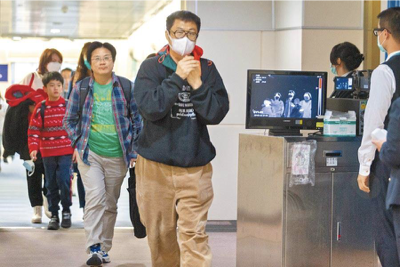

In [59]:
Image.open("/content/face-mask-detection/images/maksssksksss179.png")

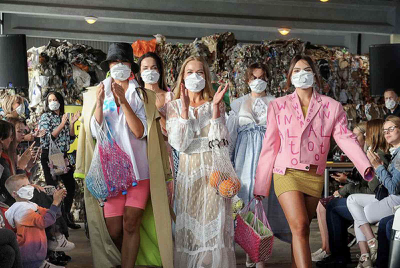

In [60]:
Image.open("/content/face-mask-detection/images/maksssksksss111.png")

## Подготовка данных

In [61]:
def xml_to_yolo_bbox(bbox, w, h):

    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):

    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2

    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)

    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"]

input_dir = "/content/face-mask-detection/annotations"
output_dir = "/content/labels"
image_dir = "/content/face-mask-detection/images"


if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

import glob

files = glob.glob(os.path.join(input_dir, "*.xml"))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []


    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text


        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)


        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:

        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding = "utf-8") as f:
            f.write("\n".join(result))

with open("/content/classes.txt", "w", encoding = "utf-8") as f:
    f.write(json.dumps(classes))

In [62]:
with open('/content/classes.txt') as f:
    contents = f.read()
    print(contents)

["without_mask", "with_mask", "mask_weared_incorrect"]


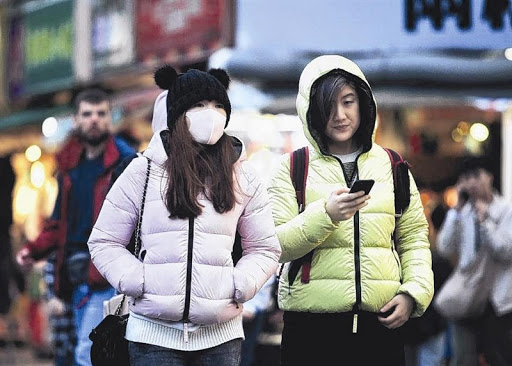

In [63]:
Image.open("/content/face-mask-detection/images/maksssksksss0.png")

## Подготовка данных для YoloV8



In [64]:
if os.path.isfile("/content/data/"):
    print("There is folder!")


In [66]:
metarial = []

for i in os.listdir("/content/face-mask-detection/images"):
    srt = i[:-4]
    metarial.append(srt)

In [67]:

def preparinbdata(main_txt_file, main_img_file, train_size, test_size, val_size):

    for i in range(0,train_size):

        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"

        mstring = metarial[i]
        train_destination_txt = "/content/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/content/data/train/images" + "/" + metarial[i] + ".png"

        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)

        #metarial.remove(file_name[:-4])


    for l in range(train_size , train_size + test_size):

        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"

        mstring = metarial[l]
        test_destination_txt = "/content/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/content/data/test/images" + "/" + metarial[l] + ".png"

        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_img, test_destination_png)

        #metarial.remove(file_name[:-4])


    for n in range(train_size + test_size , train_size + test_size + val_size):

        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"

        mstring = metarial[n]
        val_destination_txt = "/content/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/content/data/val/images" + "/" + metarial[n] + ".png"

        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)

        #metarial.remove(file_name[:-4])

In [68]:
preparinbdata("/content/labels", "/content/face-mask-detection/images", 603, 150, 100)

In [72]:
%cd /content/data

yaml_text = """train: /content/data/train/images
val: /content/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/content/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data.yaml

/content/data
train: /content/data/train/images
val: /content/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]

## Обучение модели YoloV8



In [73]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.9/112.6 GB disk)


In [75]:
# /content/data
if os.path.isfile("/content/Result/"):
    print("Dosya mevcut! (There is folder!)")
else:
    os.mkdir("/content/Result/")

%cd /content/Result/


!yolo train model=yolov8n.pt data=/content/data/data.yaml epochs=50 imgsz=640

/content/Result
100% 6.25M/6.25M [00:00<00:00, 109MB/s]
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

## Визуализация результатов

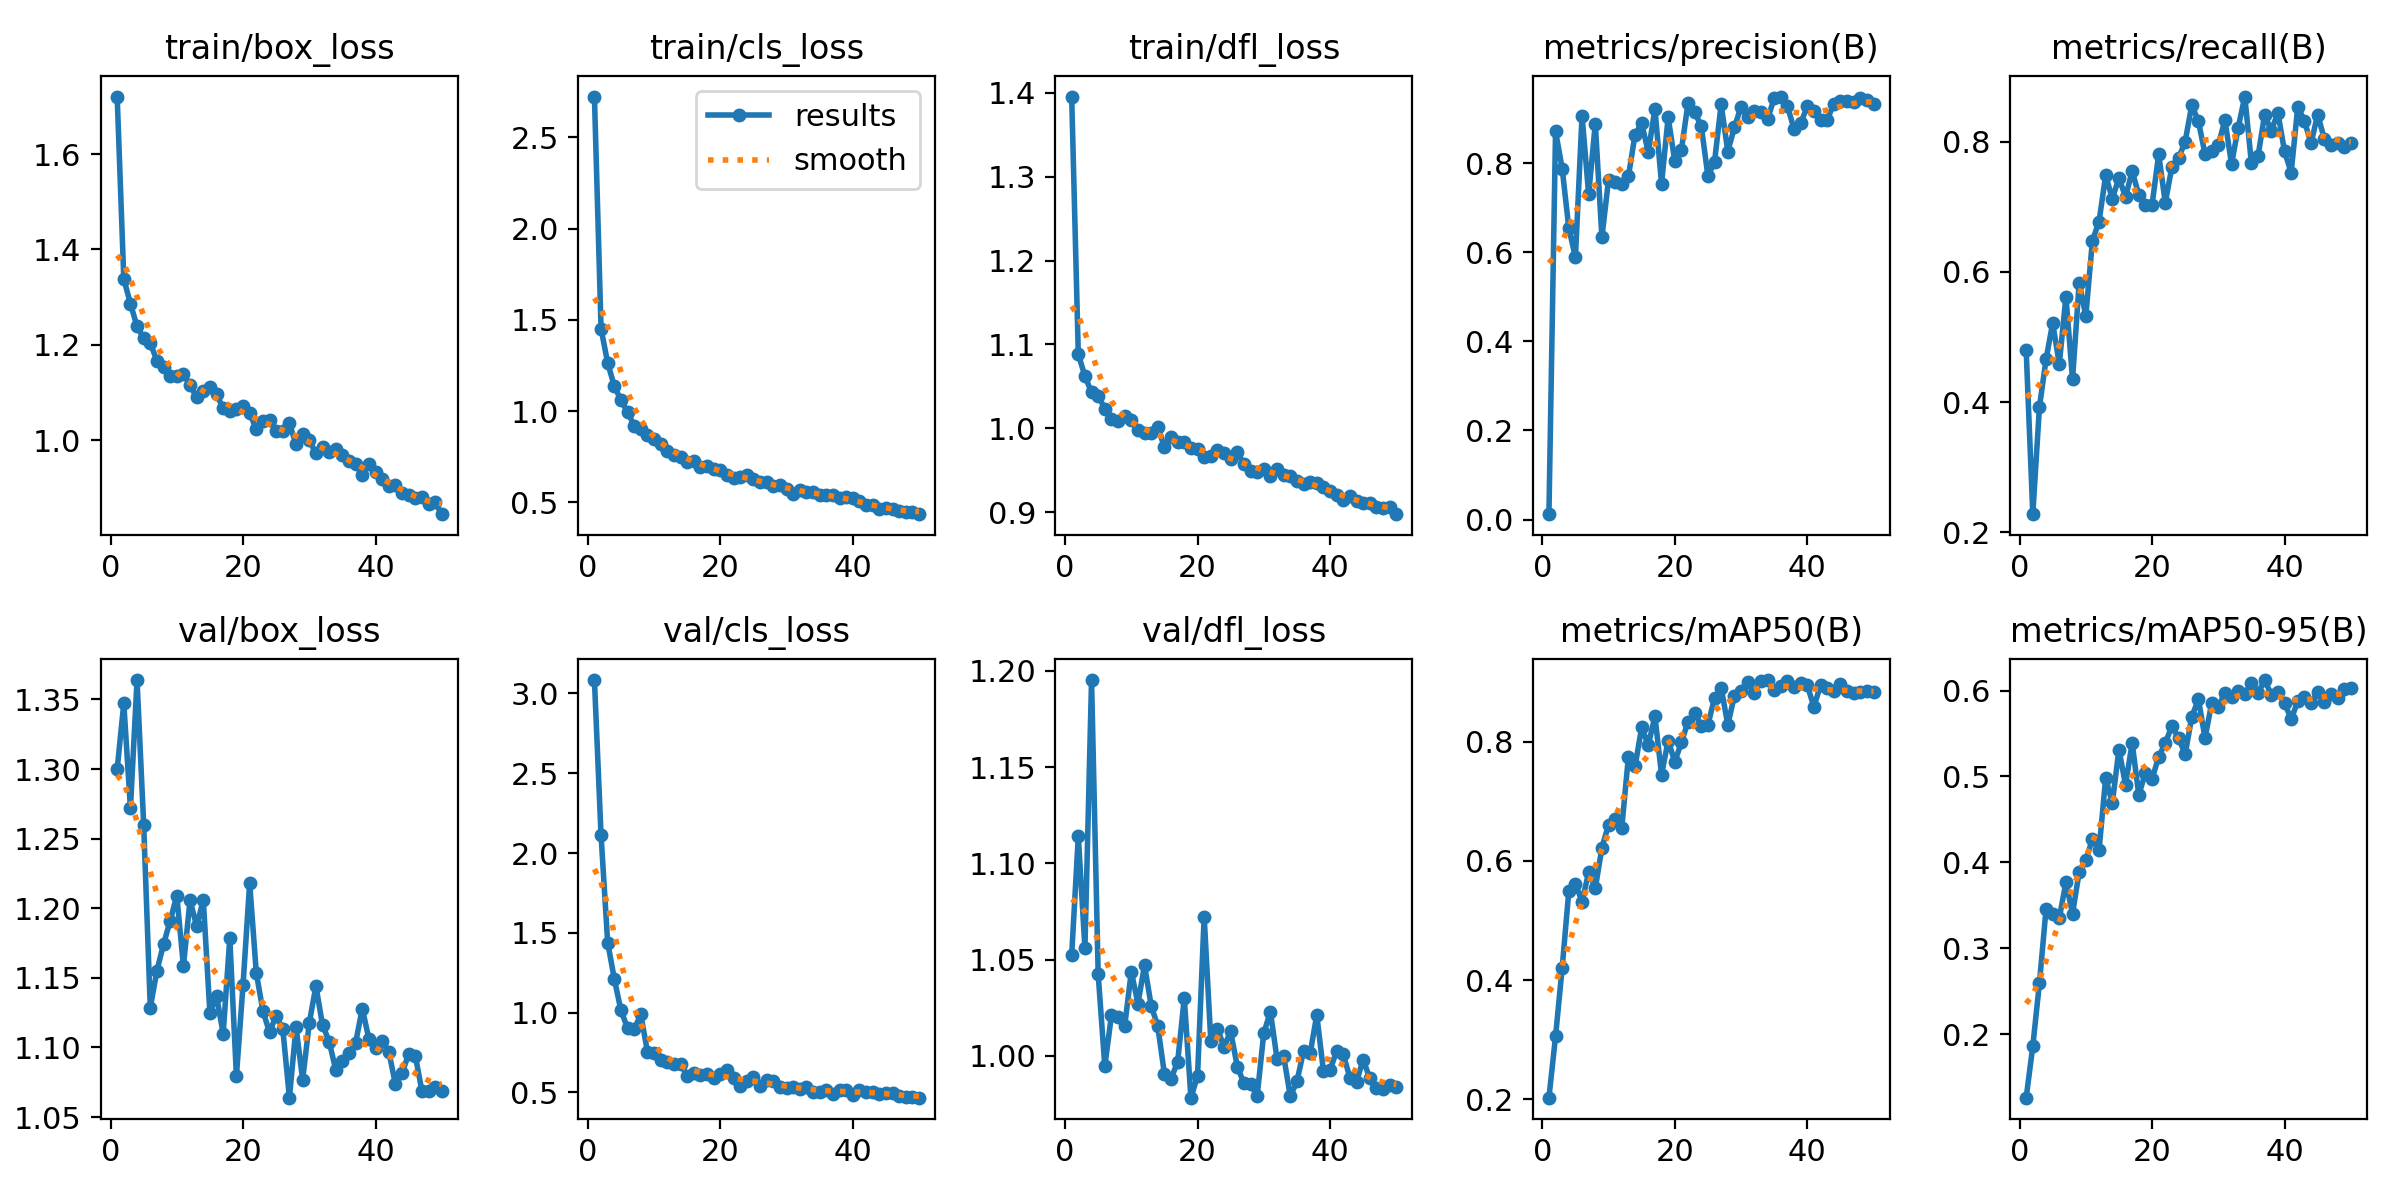

In [76]:
Image.open("/content/Result/runs/detect/train/results.png")

In [77]:
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/data/test/images'

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/150 /content/data/test/images/maksssksksss105.png: 448x640 8 with_masks, 35.7ms
image 2/150 /content/data/test/images/maksssksksss124.png: 448x640 3 without_masks, 4 with_masks, 6.8ms
image 3/150 /content/data/test/images/maksssksksss127.png: 640x448 1 with_mask, 33.3ms
image 4/150 /content/data/test/images/maksssksksss13.png: 384x640 6 with_masks, 1 mask_weared_incorrect, 42.4ms
image 5/150 /content/data/test/images/maksssksksss137.png: 640x640 4 without_masks, 3 with_masks, 12.8ms
image 6/150 /content/data/test/images/maksssksksss148.png: 608x640 3 without_masks, 2 with_masks, 37.4ms
image 7/150 /content/data/test/images/maksssksksss150.png: 640x512 1 with_mask, 34.8ms
image 8/150 /content/data/test/images/maksssksksss152.png: 480x640 7 with_masks, 34.2ms
image 9/150 /content/data/test/images/maksssksksss154.png: 6

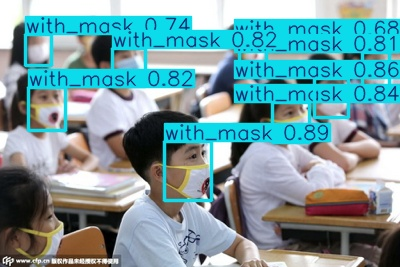

In [80]:
Image.open('/content/Result/runs/detect/predict/maksssksksss105.jpg')

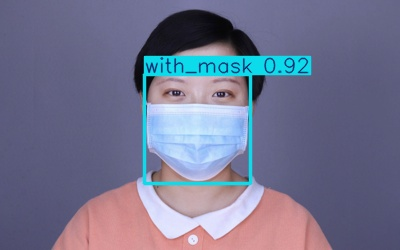

In [81]:
Image.open('/content/Result/runs/detect/predict/maksssksksss600.jpg')

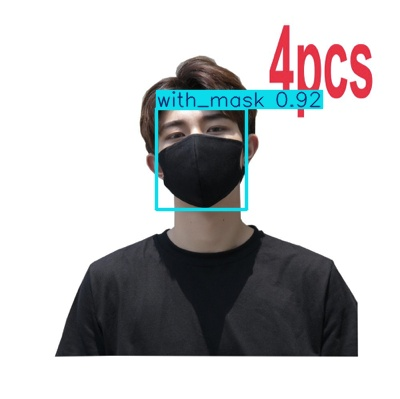

In [82]:
Image.open('/content/Result/runs/detect/predict/maksssksksss617.jpg')

## Улучшенный бейзлайн


In [84]:
import os
from pathlib import Path
from datetime import datetime


CONFIG = {
    "base_dir": "/content",
    "data_config": "data/data.yaml",
    "model_name": "yolov8n.pt",
    "training_params": {
        "epochs": 50,
        "imgsz": 640,
        "batch": 16
    },
    "output_folders": {
        "results": "Training_Results",
        "weights": "model_weights",
        "plots": "training_plots"
    }
}

def create_directory_structure(base_path: str, folders: dict) -> bool:
    """Создает структуру папок для эксперимента"""
    try:

        Path(base_path).mkdir(parents=True, exist_ok=True)


        for folder_name in folders.values():
            (Path(base_path) / folder_name).mkdir(exist_ok=True)

        print(f"Структура папок создана в: {base_path}")
        return True
    except Exception as e:
        print(f"Ошибка при создании структуры папок: {str(e)}")
        return False

def train_yolo():
    """Запускает обучение YOLO модели с новой структурой папок"""
    try:

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        experiment_name = f"exp_{timestamp}"
        experiment_dir = Path(CONFIG["base_dir"]) / experiment_name


        if not create_directory_structure(experiment_dir, CONFIG["output_folders"]):
            raise RuntimeError("Не удалось создать структуру папок")


        results_dir = experiment_dir / CONFIG["output_folders"]["results"]
        weights_dir = experiment_dir / CONFIG["output_folders"]["weights"]
        plots_dir = experiment_dir / CONFIG["output_folders"]["plots"]


        os.chdir(results_dir)
        print(f"Текущая рабочая директория: {os.getcwd()}")


        train_cmd = (
            f"yolo train model={CONFIG['model_name']} "
            f"data={Path(CONFIG['base_dir']) / CONFIG['data_config']} "
            f"epochs={CONFIG['training_params']['epochs']} "
            f"imgsz={CONFIG['training_params']['imgsz']} "
            f"batch={CONFIG['training_params']['batch']} "
            f"project={experiment_dir} "
            f"name={results_dir.name}"
        )

        print(f"Запускаем обучение с параметрами:\n{train_cmd}")
        !{train_cmd}


        print("Обучение завершено!")
        print(f"Результаты сохранены в: {experiment_dir}")

    except Exception as e:
        print(f"Ошибка во время обучения: {str(e)}")
        raise

if __name__ == "__main__":
    train_yolo()

Структура папок создана в: /content/exp_20250514_193317
Текущая рабочая директория: /content/exp_20250514_193317/Training_Results
Запускаем обучение с параметрами:
yolo train model=yolov8n.pt data=/content/data/data.yaml epochs=50 imgsz=640 batch=16 project=/content/exp_20250514_193317 name=Training_Results
100% 6.25M/6.25M [00:00<00:00, 122MB/s]
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False